In [1]:
import os
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import netneurotools.plotting, netneurotools.datasets, netneurotools.interface

import cubnm
import cubnm_paper

# set plots font and dpi
# Note: the font is not included in the repository
import matplotlib.font_manager
font_path = os.path.join(cubnm_paper.config.DATA_DIR, 'assets', 'Optima.ttc')
matplotlib.font_manager.fontManager.addfont(font_path)
font = matplotlib.font_manager.FontProperties(fname=font_path, size=12)
plt.rcParams.update({
    "font.family": font.get_name(),
    "figure.dpi": 600
})

Load optimizer:

In [2]:
cmaes = cubnm_paper.data.load_cmaes(
    sub="group-train706",
    ses="",
    het_mode="yeo",
    seed=1,
    popsize=128,
    n_iter=120,
)

# shortcut to networks map
yeo = cmaes.problem.node_grouping

In [3]:
cmaes.opt.round(3)

index            77.000
G                 1.270
w_p0              0.000
w_p1              1.247
w_p2              1.159
w_p3              0.249
w_p4              0.062
w_p5              1.341
w_p6              0.000
J_N0              0.265
J_N1              0.321
J_N2              0.307
J_N3              0.468
J_N4              0.002
J_N5              0.089
J_N6              0.069
cost             -0.338
+fc_corr          0.521
-fcd_ks          -0.170
+gof              0.351
-fic_penalty     -0.013
gen             119.000
Name: 15181, dtype: float64

# D. Method

Networks color map:

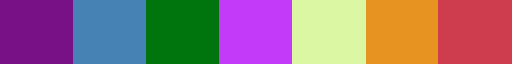

In [4]:
yeo_colors = [
    (0.470588, 0.0705882, 0.52549),
    (0.27451, 0.509804, 0.705882),
    (0.0, 0.462745, 0.054902),
    (0.768627, 0.227451, 0.980392),
    (0.862745, 0.972549, 0.643137),
    (0.901961, 0.580392, 0.133333),
    (0.803922, 0.243137, 0.305882),
]
yeo_cmap = LinearSegmentedColormap.from_list("yeo", yeo_colors, 7)
yeo_cmap

Networks surface map:

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Please cite the following papers if you are using this function:
  [primary]:
    Alexander Schaefer, Ru Kong, Evan M Gordon, Timothy O Laumann, Xi-Nian Zuo, Avram J Holmes, Simon B Eickhoff, and BT Thomas Yeo. Local-global parcellation of the human cerebral cortex from intrinsic functional connectivity mri. Cerebral cortex, 28(9):3095–3114, 2018.
Dataset atl-schaefer2018 already exists. Skipping download.


/u/asaberi/projects/cubnm/paper/venv/lib/python3.10/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


2025-11-12 09:05:52.347 ( 224.633s) [    14991AF9EB80]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=
2025-11-12 09:05:52.416 ( 224.701s) [    14991AF9EB80] vtkEGLRenderWindow.cxx:385   WARN| vtkEGLRenderWindow (0x15001b30): Setting an EGL display to device index: -1 require EGL_EXT_device_base EGL_EXT_platform_device EGL_EXT_platform_base extensions
2025-11-12 09:05:52.416 ( 224.701s) [    14991AF9EB80] vtkEGLRenderWindow.cxx:390   WARN| vtkEGLRenderWindow (0x15001b30): Attempting to use EGL_DEFAULT_DISPLAY...
2025-11-12 09:05:52.416 ( 224.701s) [    14991AF9EB80] vtkEGLRenderWindow.cxx:395   WARN| vtkEGLRenderWindow (0x15001b30): Could not initialize a device. Exiting...
2025-11-12 09:05:52.416 ( 224.701s) [    14991AF9EB80]vtkOpenGLRenderWindow.c:793   WARN| vtkEGLRenderWindow (0x15001b30): Failed to initialize OpenGL functions!
2025-11-12 09:05:52.416 ( 224.701s) [    14991AF9EB80]vtkOpenGLRenderWindow.c:812   WARN| vtkEGLRenderWindow (0x15001b30): Unable to f

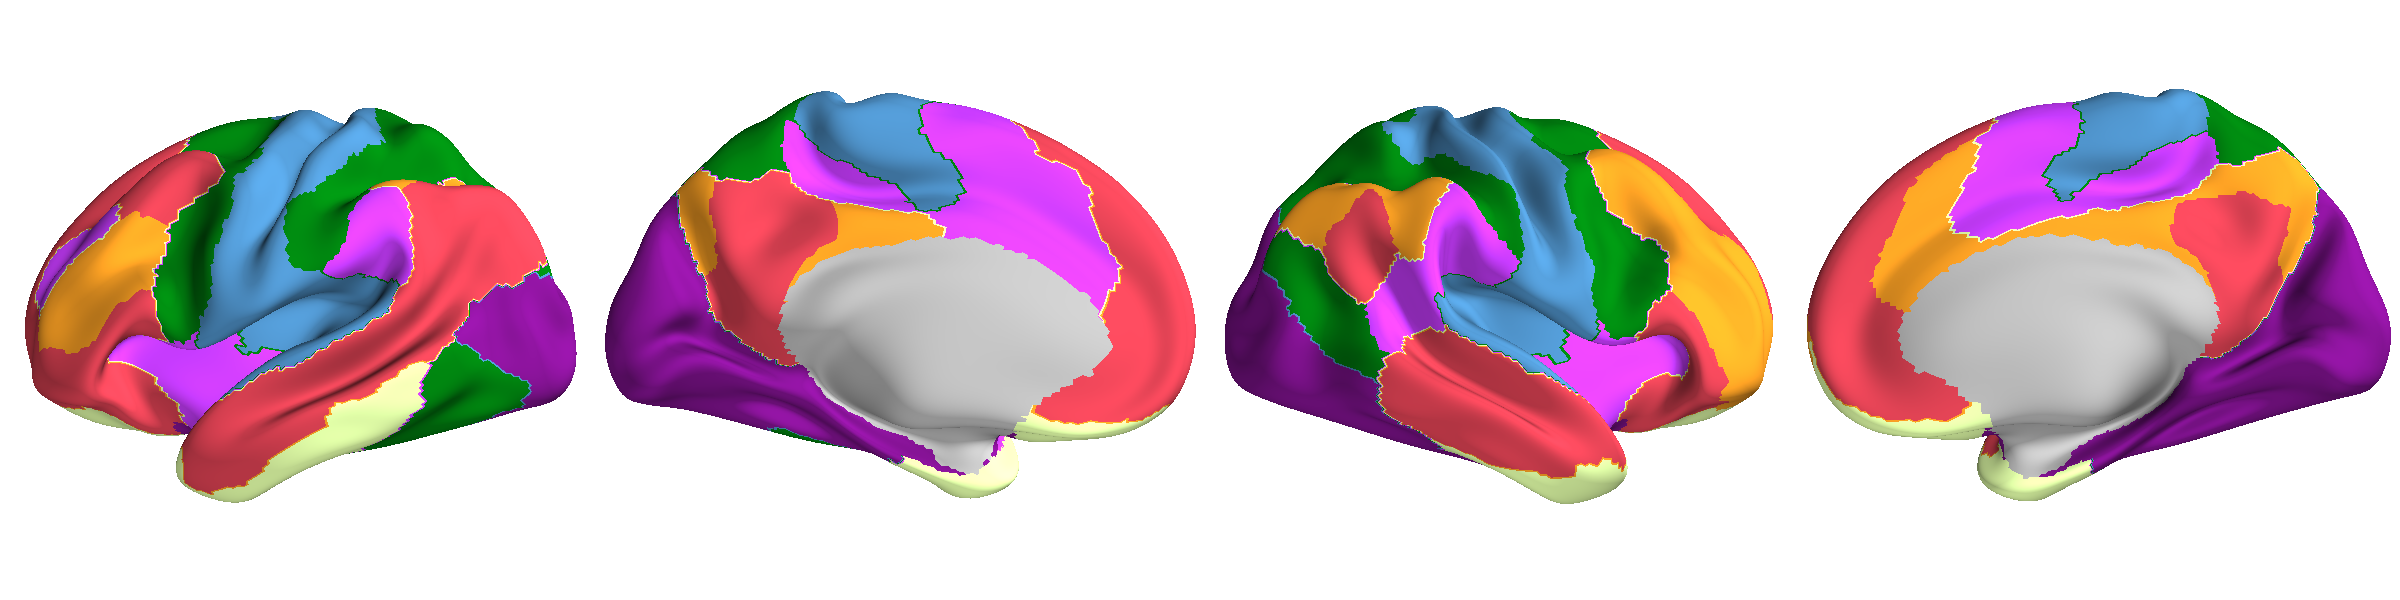

In [5]:
plotter = cubnm_paper.utils.plot_parc(yeo, cmap=yeo_cmap)
_ = plotter.screenshot('Yeo_surf.png', transparent_background=True)

Legend:

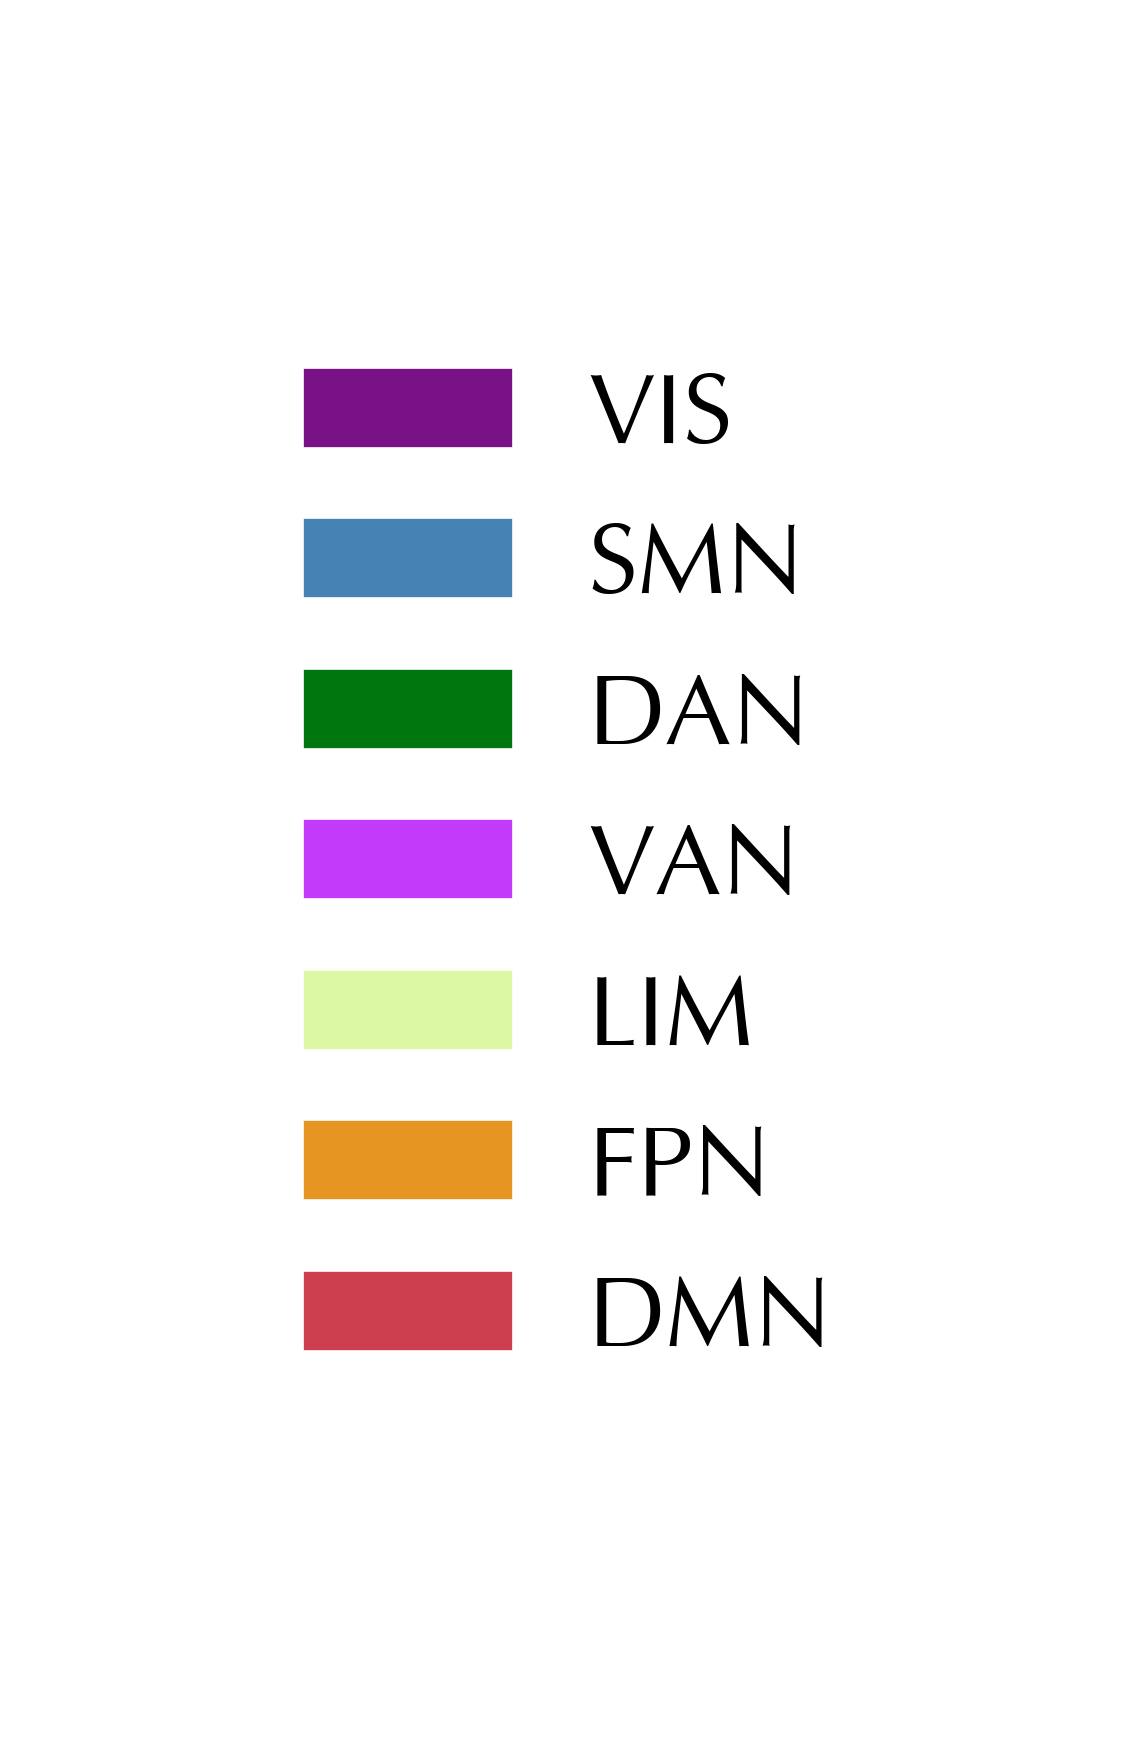

In [5]:
network_names = ['VIS', 'SMN', 'DAN', 'VAN', 'LIM', 'FPN', 'DMN']

# Create figure with just the legend
fig, ax = plt.subplots(figsize=(2, 3))
ax.axis('off')

# Create legend patches
patches = [matplotlib.patches.Patch(color=yeo_colors[i], label=network_names[i]) 
           for i in range(len(network_names))]

# Create the legend
legend = ax.legend(handles=patches, loc='center', fontsize=12, frameon=False)

plt.tight_layout()
plt.savefig('yeo_legend.png', transparent=True, bbox_inches='tight')
plt.show()

Plot tunable parameters:

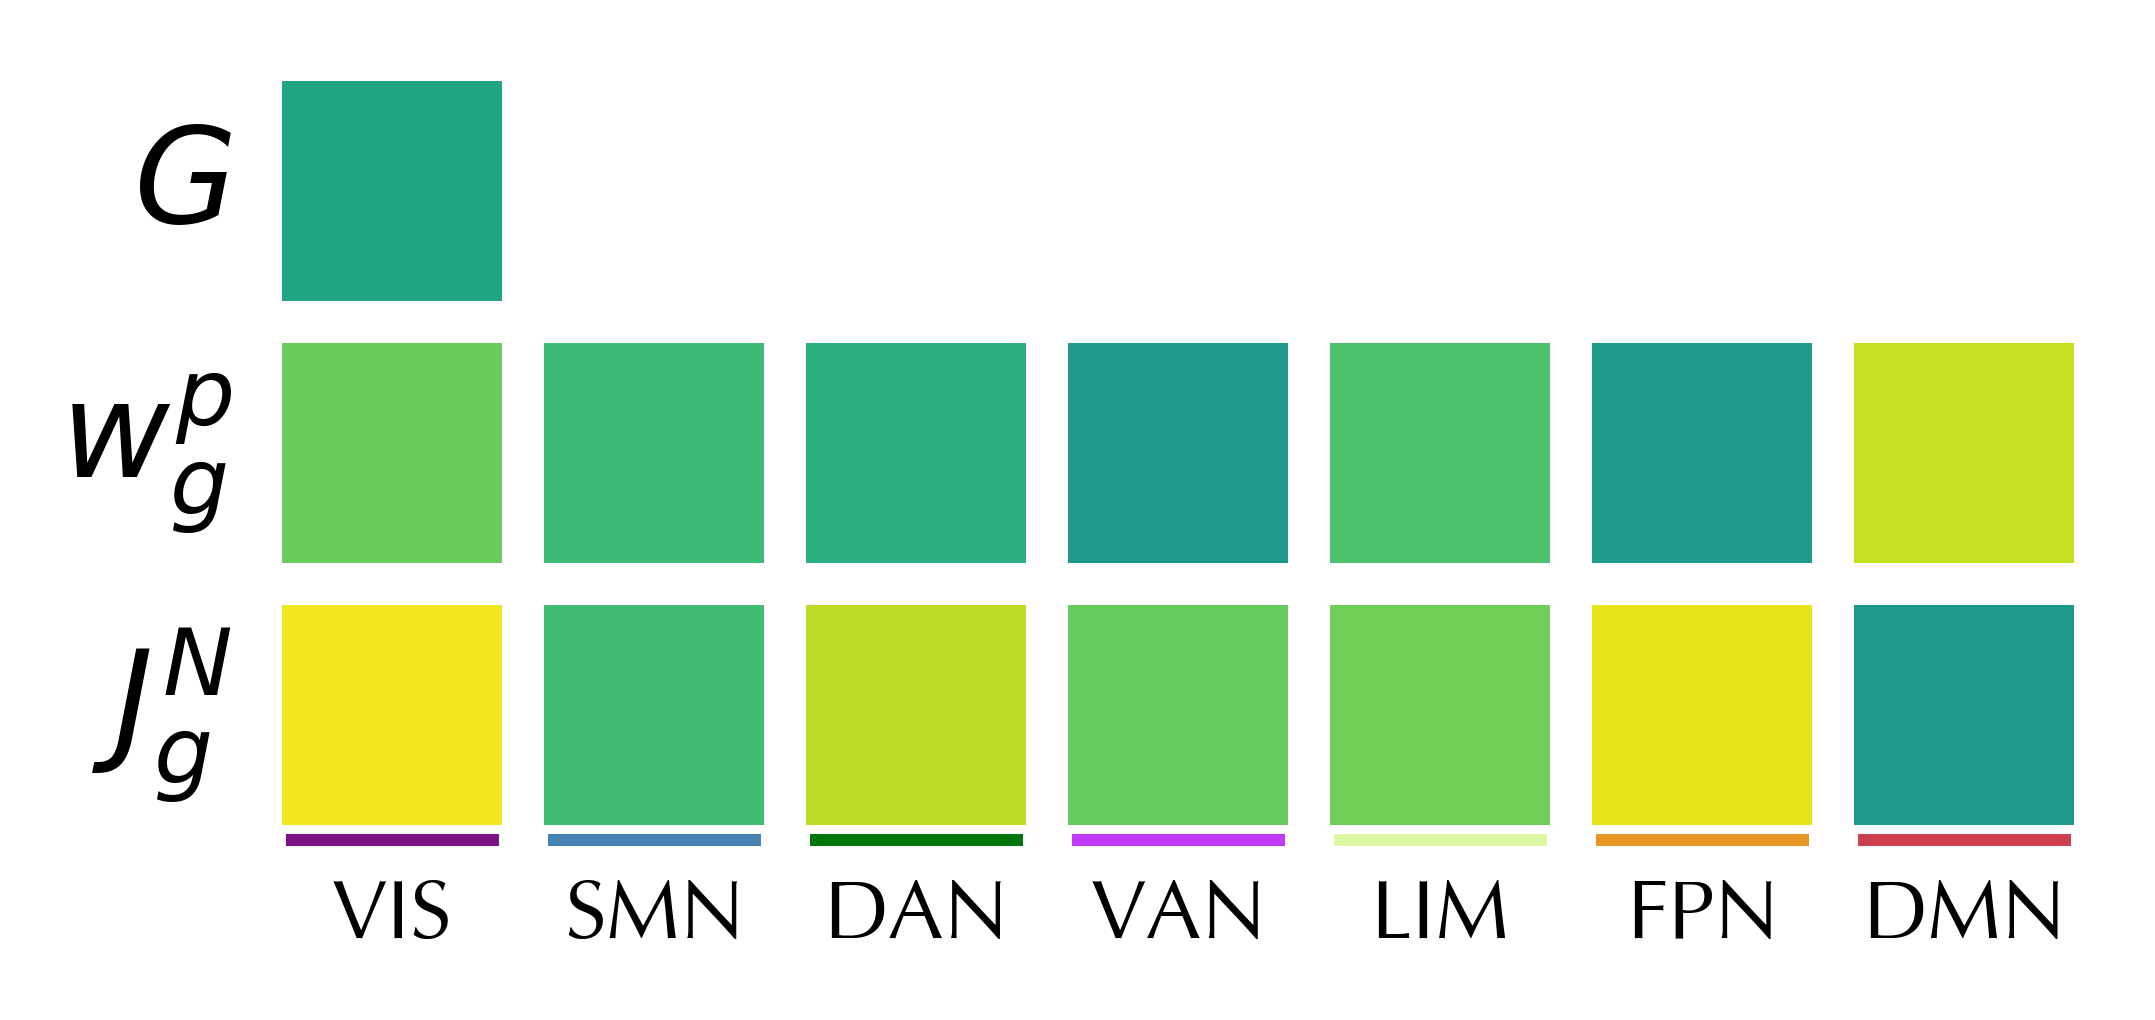

In [6]:
np.random.seed(0)
example_params = np.concatenate([
    np.random.rand(1) * (10 - 0.001) + 0.001, # G
    np.random.rand(7) * (2 - 0) + 0, # w_p
    np.random.rand(7) * (0.5 - 0.001) + 0.001, # J_N
])
example_params = pd.Series(example_params, index=cmaes.opt.iloc[1:16].index)
labels = {
    'G': r'$G$', 
}

for param in example_params.index:
    if '_' in param:
        label1, label2 = param.split('_')
        network = label2[-1]
        label2 = label2[:-1]
        labels[param] = r'$' + label1 + '_' + str(network) + '^' + label2 + r'$'                     

fig, axes = plt.subplots(3, 1, figsize=(3.5, 1.5))
# G
ax = axes[0]
plot_data = example_params.iloc[:7].copy()
plot_data.iloc[1:] = np.nan
plot_data.index = ['G'] + [''] * 6
sns.heatmap(plot_data.to_frame().T, ax=ax, cbar=False, cmap='viridis', linewidth=5, square=True, vmin=-1, vmax=10)
ax.set_xticks([])
ax.set_yticklabels([r'$G$'], fontsize=16, rotation=0)
ax.tick_params(axis='y', which='both', length=0)


# w_p
ax = axes[1]
plot_data = example_params.iloc[1:8].copy()
sns.heatmap(plot_data.to_frame().T, ax=ax, cbar=False, cmap='viridis', linewidth=5, square=True, vmin=-0.5, vmax=2)
ax.set_xticks([])
ax.set_yticklabels([r'$w_g^p$'], fontsize=16, rotation=0)
ax.tick_params(axis='y', which='both', length=0)

# J_N
ax = axes[2]
plot_data = example_params.iloc[8:].copy()
sns.heatmap(plot_data.to_frame().T, ax=ax, cbar=False, cmap='viridis', linewidth=5, square=True, vmin=-0.5, vmax=0.5)
ax.set_yticklabels([r'$J_g^N$'], fontsize=16, rotation=0)
ax.tick_params(axis='y', which='both', length=0)

# network indicators
pad = 0.02
for i in range(7):
    length = (1/7)
    ax.axhline(
        1, 
        xmin=i*length+pad, 
        xmax=(i+1)*length-pad, 
        color=yeo_colors[i], 
        linewidth=3, 
        alpha=1.0
    )
    
# network labels
# ax.set_xticks([])
ax.set_xticklabels(["VIS", "SMN", "DAN", "VAN", "LIM", "FPN", "DMN"])
ax.tick_params(axis='x', which='both', length=0)


fig.tight_layout(pad=0)

fig.savefig('Yeo_params.png', transparent=True)

# E-F. Cost and parameters history

In [7]:
# transform history parameters to normalized space
hist_X = cmaes.problem._get_X(cmaes.history.loc[:, cmaes.problem.free_params])
# convert optimizer parameters (n = 7) to model parameters (n = 1 + 100 + 100)
# by calling `_get_sim_params()` method
hist_params = cmaes.problem._get_sim_params(hist_X)

/tmp/ipykernel_10681/2289281609.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
/tmp/ipykernel_10681/2289281609.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)


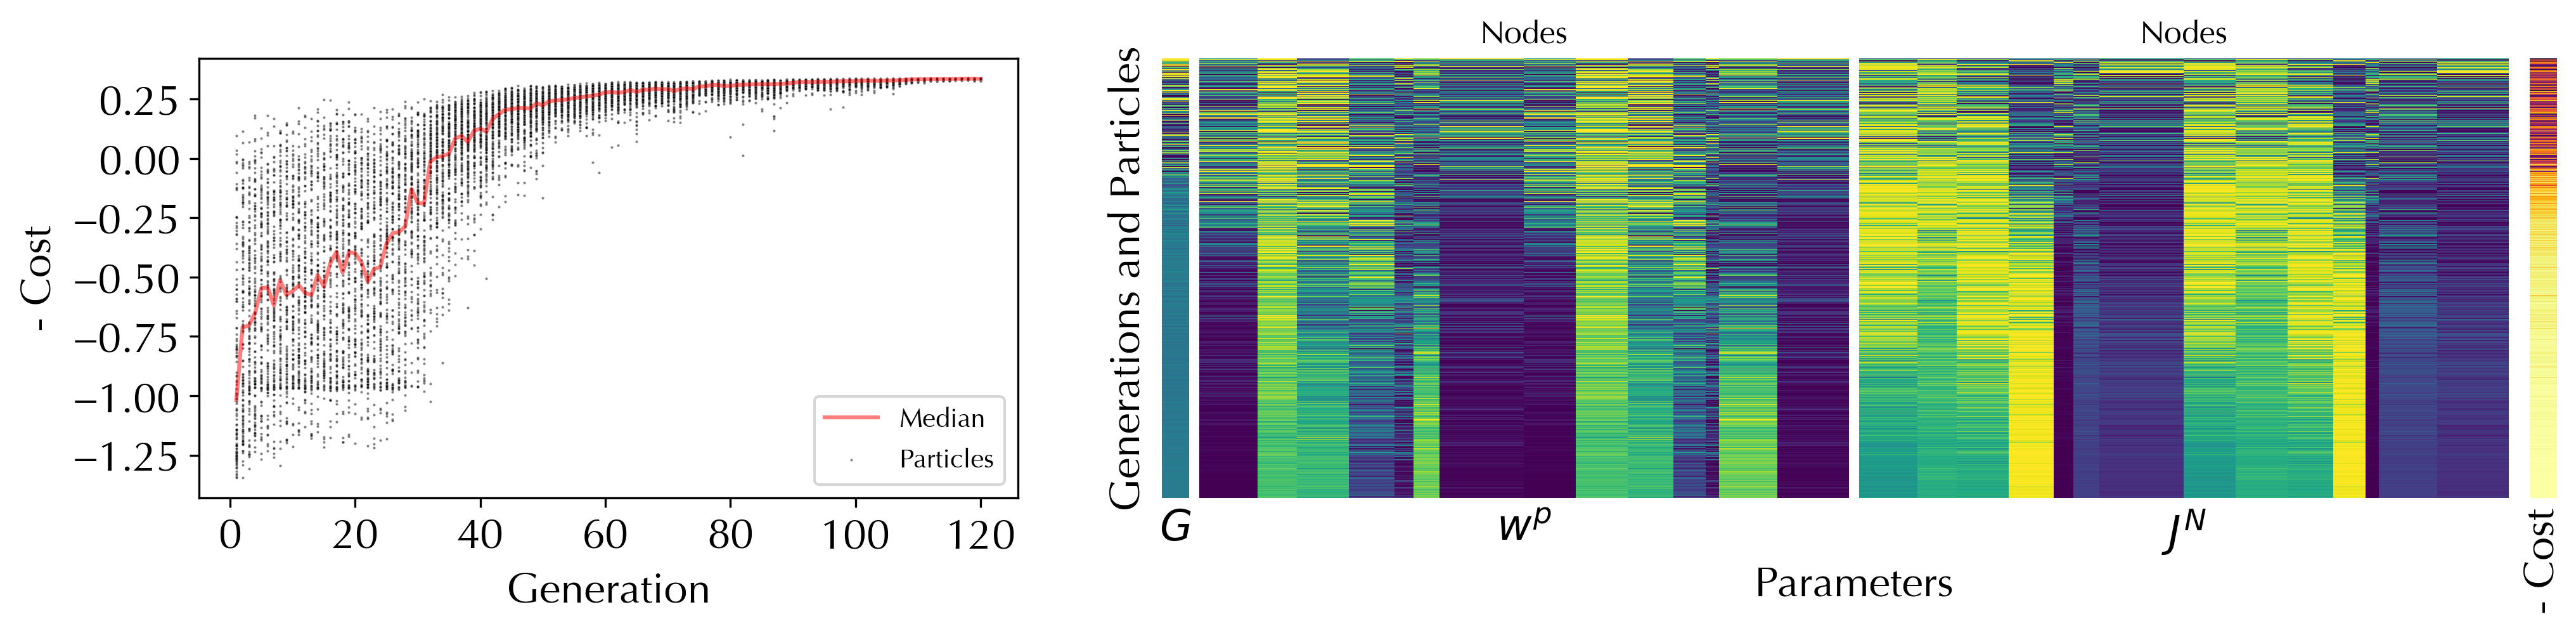

In [8]:
fig, axd = plt.subplot_mosaic(
    [["hist"] + ["space0"] + ["G"] + ["space1"] + ["w_p"] * 100 + ["title"] + ["J_N"] * 100 + ["space2"] + ["fit"]],
    gridspec_kw=dict(width_ratios=[300] + [50] + [10] + [1] * 202 + [5, 10]),
    figsize=(16, 3), dpi=300
)

# Left: cost history

ax = axd['hist']
cmaes.plot_history(
    '-cost', 
    scatter_kws=dict(
        s=1,
    ),
    ax=ax
)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)

# Right: history of global/regional parameters and associated cost
# plot normalized cost
hist_fit = -cmaes.history.loc[:, ['cost']]
hist_fit = (hist_fit - hist_fit.min(axis=0)) / (hist_fit.max(axis=0) - hist_fit.min(axis=0))

vmins = {
    'G': np.nanmin(hist_params['G']),
    'w_p': np.nanmin(hist_params['w_p']),
    'J_N': np.nanmin(hist_params['J_N']),
    'fit': 0,
}
vmaxs = {
    'G': np.nanquantile(hist_params['G'], 0.95),
    'w_p': np.nanquantile(hist_params['w_p'], 0.95),
    'J_N': np.nanquantile(hist_params['J_N'], 0.95),
    'fit': 1
}

# plot separate heatmaps for each parameter+cost
sns.heatmap(hist_params['G'][:, None], ax=axd['G'], cbar=False, cmap='viridis', vmin=vmins['G'], vmax=vmaxs['G'])
axd['G'].set_xlabel(r'$G$', fontsize=16)
sns.heatmap(hist_params['w_p'][:, :], ax=axd['w_p'], cbar=False, cmap='viridis', vmin=vmins['w_p'], vmax=vmaxs['w_p'])
axd['w_p'].set_xlabel(r'$w^{p}$', fontsize=16)
sns.heatmap(hist_params['J_N'][:, :], ax=axd['J_N'], cbar=False, cmap='viridis', vmin=vmins['J_N'], vmax=vmaxs['J_N'])
axd['J_N'].set_xlabel(r'$J^{N}$', fontsize=16)
sns.heatmap(hist_fit, ax=axd['fit'], cbar=False, cmap='inferno', vmin=0, vmax=1)
axd['fit'].set_xlabel('- Cost', fontsize=16, rotation=90)

# title and aesthetics
axd['title'].set_xlabel('Parameters', fontsize=16, labelpad=25)
for name, ax in axd.items():
    if name == 'hist':
        continue
    sns.despine(ax=ax, left=True, bottom=True, right=True, top=True)
    ax.set_xticks([])
    ax.set_yticks([])
axd['G'].set_ylabel('Generations and Particles', fontsize=16)
axd['w_p'].set_title('Nodes', fontsize=12)
axd['J_N'].set_title('Nodes', fontsize=12)
fig.subplots_adjust(wspace=0.5)
fig.savefig('cmaes_yeo_map_hist_both.png', transparent=True, bbox_inches='tight')

# Text. Test fit

Create a `rWWSimGroup` using test dataset's SC, apply optimal parameters (obtained from the train dataset), and assess its score against empirical FC and FCD of test dataset:

In [3]:
test_data = dict(
    sc = cubnm.datasets.load_sc('strength', sub='group-test303'),
    emp_fc_tril = cubnm.datasets.load_fc(sub='group-test303', exc_interhemispheric=True),
    emp_fcd_tril = cubnm.datasets.load_fcd(sub='group-test303', exc_interhemispheric=True)
)

sim_options = copy.deepcopy(cubnm_paper.config.HCP_SIM_OPTIONS)

test_sg = cubnm.sim.rWWSimGroup(
    sc = test_data['sc'],
    **sim_options
)

# set N and parameters
test_sg.N = 1
test_sg.param_lists['G'] = cmaes.opt_sim_data['G'].copy()
test_sg.param_lists['w_p'] = cmaes.opt_sim_data['w_p'].copy()
test_sg.param_lists['J_N'] = cmaes.opt_sim_data['J_N'].copy()
test_sg._set_default_params(missing=True) # default parameters (sigma)
# run and score simulation
test_sg.run()
score = test_sg.score(
    emp_fc_tril=test_data['emp_fc_tril'],
    emp_fcd_tril=test_data['emp_fcd_tril']
)
# add cost
score['cost'] = -(score['+gof'] + score['-fic_penalty'])
score.round(3)

Initializing CPU session...
Precalculating 60000000 noise elements...
noise will be repeated 30 times (nodes [rows] and timepoints [columns] will be shuffled in each repeat)
took 2.915319 s
Running 1 simulations...
nodes: 100
N_SIMS: 1
N_SCs: 1
BOLD_TR: 720
states_sampling: 720
time_steps: 900000
do_delay: 0
sim_seed: 0
exc_interhemispheric: 1
verbose: 1
progress_interval: 500
bold_remove_s: 30
drop_edges: 1
ext_out: 1
do_fc: 1
do_fcd: 1
states_ts: 0
noise_time_steps: 30000
Thread 0 (of 12) is executing particle 0 [08:45:33]
Simulations completed
Simulations and calculation of FC and FCD took 117.097258 s


,+fc_corr,-fcd_ks,+gof,-fic_penalty,cost
0,0.508,-0.168,0.34,-0.014,-0.327
